In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
import math
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Activation, Reshape

#Load and Prepare Data

In [2]:
# load the data for each subset
def load_dataframe(subset_number):
    directory = 'C-MAPSS/'
    if not os.path.exists(directory):
        os.makedirs(directory)

    train_url = f"https://raw.githubusercontent.com/DemetraAS/C-MAPSS/main/train_FD00{subset_number}.txt"
    os.system(f"wget -q {train_url} -O {directory}train_FD00{subset_number}.txt")
    turbo_train = pd.read_csv(f"{directory}train_FD00{subset_number}.txt", sep='\s+', header=None, index_col=False)

    test_url = f"https://raw.githubusercontent.com/DemetraAS/C-MAPSS/main/test_FD00{subset_number}.txt"
    os.system(f"wget -q {test_url} -O {directory}test_FD00{subset_number}.txt")
    turbo_test = pd.read_csv(f"{directory}test_FD00{subset_number}.txt", sep='\s+', header=None, index_col=False)

    rul_url = f"https://raw.githubusercontent.com/DemetraAS/C-MAPSS/main/RUL_FD00{subset_number}.txt"
    os.system(f"wget -q {rul_url} -O {directory}RUL_FD00{subset_number}.txt")
    y_RUL = pd.read_csv(f"{directory}RUL_FD00{subset_number}.txt", sep='\s+', header=None, index_col=False)

    return turbo_train, turbo_test, y_RUL

In [3]:
turbo_train_1, turbo_test_1, y_RUL_1 = load_dataframe(1)
turbo_train_2, turbo_test_2, y_RUL_2 = load_dataframe(2)
turbo_train_3, turbo_test_3, y_RUL_3 = load_dataframe(3)
turbo_train_4, turbo_test_4, y_RUL_4 = load_dataframe(4)

In [4]:
turbo_train_1

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [5]:
def count_engines(turbofan):
  unique_engines = turbofan[0].unique()
  num_engines = len(unique_engines)
  return num_engines

In [6]:
nr_train_1=count_engines(turbo_train_1)
nr_train_2=count_engines(turbo_train_2)
nr_train_3=count_engines(turbo_train_3)
nr_train_4=count_engines(turbo_train_4)
nr_test_1=count_engines(turbo_test_1)
nr_test_2=count_engines(turbo_test_2)
nr_test_3=count_engines(turbo_test_3)
nr_test_4=count_engines(turbo_test_4)

In [7]:
# assign the original RUL to the training set (here RUL decreases linearly)
def original_RUL_train(turbo_train):
  turbo_train.sort_values(by=[0, 1], inplace=True)
  turbo_train['RUL'] = turbo_train.groupby(0).cumcount(ascending=False)
  return turbo_train

In [8]:
turbo_train_1=original_RUL_train(turbo_train_1)
turbo_train_2=original_RUL_train(turbo_train_2)
turbo_train_3=original_RUL_train(turbo_train_3)
turbo_train_4=original_RUL_train(turbo_train_4)

In [9]:
turbo_train_1

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [10]:
 # assign the original RUL to the testing set (RUL decreases linearly)
def original_RUL_test(turbo_test, y_RUL):
  y_RUL_series=y_RUL[0]
  turbo_test.sort_values(by=[0, 1], inplace=True)
  adjusted_engine_numbers = turbo_test[0].values - 1
  turbo_test['RUL'] = turbo_test.groupby(0).cumcount(ascending=False) + y_RUL_series.iloc[adjusted_engine_numbers].values
  return turbo_test

In [11]:
turbo_test_1=original_RUL_test(turbo_test_1, y_RUL_1)
turbo_test_2=original_RUL_test(turbo_test_2, y_RUL_2)
turbo_test_3=original_RUL_test(turbo_test_3, y_RUL_3)
turbo_test_4=original_RUL_test(turbo_test_4, y_RUL_4)

In [12]:
turbo_test_1

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [13]:
#concatenate training and testing set for subsequent operations (reset engines indexes for training set)
def complete_dataframe(turbo_train, turbo_test):
  turbo_test_reset = turbo_test.reset_index(drop=True)
  last_engine = turbo_train[0].iloc[-1]
  turbo_test_reset[0] += last_engine
  turbofan = pd.concat([turbo_train, turbo_test_reset], ignore_index=True)
  return turbofan

In [14]:
turbofan1=complete_dataframe(turbo_train_1, turbo_test_1)
turbofan2=complete_dataframe(turbo_train_2, turbo_test_2)
turbofan3=complete_dataframe(turbo_train_3, turbo_test_3)
turbofan4=complete_dataframe(turbo_train_4, turbo_test_4)

In [15]:
turbofan1

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
33723,200,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
33724,200,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
33725,200,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [16]:
# rename columns as in the original paper
def rename_columns(turbofan):
  new_columns = ['ENr', 'C', 'OP-1', 'OP-2', 'OP-3',
                 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi',
                 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf-dmd', 'PCNfR-dmd', 'W31', 'W32', 'RUL']
  turbofan.columns = new_columns
  return turbofan

In [17]:
turbofan1=rename_columns(turbofan1)
turbofan2=rename_columns(turbofan2)
turbofan3=rename_columns(turbofan3)
turbofan4=rename_columns(turbofan4)

In [18]:
turbofan1

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf-dmd,PCNfR-dmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
33723,200,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
33724,200,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
33725,200,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


#Preprocessing

##Normalization

In [19]:
# perform z-score normalization (standardization)
def z_score(turbofan):
  scaler = StandardScaler()
  normalized_turbo = turbofan.copy()
  columns_to_normalize = turbofan.columns.drop(['ENr', 'C', 'RUL'])
  normalized_turbo[columns_to_normalize] = scaler.fit_transform(turbofan[columns_to_normalize])
  return normalized_turbo

In [20]:
normalized_turbo1=z_score(turbofan1)
normalized_turbo2=z_score(turbofan2)
normalized_turbo3=z_score(turbofan3)
normalized_turbo4=z_score(turbofan4)

In [21]:
normalized_turbo1

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf-dmd,PCNfR-dmd,W31,W32,RUL
0,1,1,-0.314711,-1.373690,0.0,0.0,-1.644975,0.020217,-0.794964,-3.552714e-15,...,-0.981906,-0.199424,-0.461431,-1.387779e-17,-0.655669,0.0,0.0,1.254019,1.091572,191
1,1,2,0.870755,-1.032895,0.0,0.0,-0.949920,0.383216,-0.493750,-3.552714e-15,...,-0.242468,-0.634651,-0.113571,-1.387779e-17,-0.655669,0.0,0.0,0.902637,1.136638,190
2,1,3,-1.956125,1.011877,0.0,0.0,-0.528674,-0.272579,-0.368046,-3.552714e-15,...,-0.834018,-0.528438,-0.509509,-1.387779e-17,-2.018065,0.0,0.0,0.609819,0.358754,189
3,1,4,0.323617,-0.010509,0.0,0.0,-0.528674,-1.162954,-0.644357,-3.552714e-15,...,-0.094581,-0.491813,-1.912263,-1.387779e-17,-0.655669,0.0,0.0,0.199874,0.649726,188
4,1,5,-0.861849,-0.692099,0.0,0.0,-0.486549,-1.152680,-0.128498,-3.552714e-15,...,-0.686131,-0.493645,-0.181446,-1.387779e-17,0.025530,0.0,0.0,0.317001,0.948535,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,2.238601,-0.010509,0.0,0.0,1.345871,1.689670,1.006393,-3.552714e-15,...,-1.277681,4.357951,1.009197,-1.387779e-17,0.706728,0.0,0.0,-1.147090,-1.079451,24
33723,200,195,-0.497090,-0.351304,0.0,0.0,1.303746,1.045861,1.748756,-3.552714e-15,...,0.053306,4.209620,0.435087,-1.387779e-17,1.387926,0.0,0.0,-1.615598,-0.298627,23
33724,200,196,-0.269116,-1.032895,0.0,0.0,1.767116,0.610947,-0.057345,-3.552714e-15,...,-0.686131,4.599676,0.596290,-1.387779e-17,1.387926,0.0,0.0,-1.322780,-1.004014,22
33725,200,197,-1.728151,0.330287,0.0,0.0,1.387995,0.926002,1.429753,-3.552714e-15,...,-0.094581,4.797451,0.997885,-1.387779e-17,1.387926,0.0,0.0,-1.088526,-0.369166,21


In [22]:
#split dataframe into train and test
def split_dataframe(normalized_turbofan, nr_train):
  turbo_RUL_train = normalized_turbofan[(normalized_turbofan['ENr'] <= nr_train)]
  turbo_RUL_test = normalized_turbofan[(normalized_turbofan['ENr'] > nr_train)]
  return turbo_RUL_train, turbo_RUL_test

In [23]:
turbo1_train, turbo1_test=split_dataframe(normalized_turbo1, nr_train_1)
turbo2_train, turbo2_test=split_dataframe(normalized_turbo2, nr_train_2)
turbo3_train, turbo3_test=split_dataframe(normalized_turbo3, nr_train_3)
turbo4_train, turbo4_test=split_dataframe(normalized_turbo4, nr_train_4)

In [24]:
turbo1_train

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf-dmd,PCNfR-dmd,W31,W32,RUL
0,1,1,-0.314711,-1.373690,0.0,0.0,-1.644975,0.020217,-0.794964,-3.552714e-15,...,-0.981906,-0.199424,-0.461431,-1.387779e-17,-0.655669,0.0,0.0,1.254019,1.091572,191
1,1,2,0.870755,-1.032895,0.0,0.0,-0.949920,0.383216,-0.493750,-3.552714e-15,...,-0.242468,-0.634651,-0.113571,-1.387779e-17,-0.655669,0.0,0.0,0.902637,1.136638,190
2,1,3,-1.956125,1.011877,0.0,0.0,-0.528674,-0.272579,-0.368046,-3.552714e-15,...,-0.834018,-0.528438,-0.509509,-1.387779e-17,-2.018065,0.0,0.0,0.609819,0.358754,189
3,1,4,0.323617,-0.010509,0.0,0.0,-0.528674,-1.162954,-0.644357,-3.552714e-15,...,-0.094581,-0.491813,-1.912263,-1.387779e-17,-0.655669,0.0,0.0,0.199874,0.649726,188
4,1,5,-0.861849,-0.692099,0.0,0.0,-0.486549,-1.152680,-0.128498,-3.552714e-15,...,-0.686131,-0.493645,-0.181446,-1.387779e-17,0.025530,0.0,0.0,0.317001,0.948535,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.177926,-1.032895,0.0,0.0,1.872428,1.437968,2.529067,-3.552714e-15,...,2.567393,-0.261686,1.690777,-1.387779e-17,2.750323,0.0,0.0,-2.084107,-3.273007,4
20627,100,197,-0.725065,-1.714485,0.0,0.0,1.977739,2.554361,3.116080,-3.552714e-15,...,1.975843,-0.328832,2.208325,-1.387779e-17,1.387926,0.0,0.0,-3.196816,-1.451738,3
20628,100,198,0.186832,-0.010509,0.0,0.0,1.724992,2.205060,2.475703,-3.552714e-15,...,2.271618,-0.051092,3.642188,-1.387779e-17,3.431521,0.0,0.0,-2.376925,-3.666848,2
20629,100,199,-0.497090,1.011877,0.0,0.0,1.324808,2.684493,2.280032,-3.552714e-15,...,2.123731,-0.158526,2.915358,-1.387779e-17,1.387926,0.0,0.0,-3.255380,-2.386375,1


##Prepare for Training

In [25]:
#split data into arrays
def train_split(turbo_train, turbo_test):
  X_train=turbo_train.iloc[:, :-1]
  y_train=turbo_train.iloc[:, -1]

  X_test=turbo_test.iloc[:, :-1]
  y_test=turbo_test.iloc[:, -1]
  return X_train, y_train, X_test, y_test

In [26]:
X_train, y_train, X_test, y_test=train_split(turbo1_train, turbo1_test)
y_test

20631    142
20632    141
20633    140
20634    139
20635    138
        ... 
33722     24
33723     23
33724     22
33725     21
33726     20
Name: RUL, Length: 13096, dtype: int64

In [27]:
X2_train, y2_train, X2_test, y2_test=train_split(turbo2_train, turbo2_test)
X3_train, y3_train, X3_test, y3_test=train_split(turbo3_train, turbo3_test)
X4_train, y4_train, X4_test, y4_test=train_split(turbo4_train, turbo4_test)

#Neural Networks construction

In [28]:
#testing the asymmetric scoring function
def PHME_score(y_true, y_pred):
    dif=y_pred-y_true
    if dif>=0:
      score= math.exp(dif /10)-1
    else:
      score= math.exp(-dif /13)-1
    return score

In [29]:
print("Score for an overestimation: ", PHME_score(112, 192))
print("Score for an underestimation: ", PHME_score(192, 112))

Score for an overestimation:  2979.9579870417283
Score for an underestimation:  469.5236172558757


In [30]:
#metrics for the neural networks
def RMSE(y_true, y_pred):
    squared_errors = tf.square(y_true - y_pred)
    individual_rmse = tf.sqrt(tf.reduce_mean(squared_errors, axis=-1))
    return tf.keras.backend.mean(individual_rmse)

def PHME_score(y_true, y_pred):
    dif = y_pred - y_true
    positive_score = tf.exp(-dif / 13) - 1
    negative_score = tf.exp(-dif / 10) - 1
    individual_score = tf.where(dif >= 0, positive_score, negative_score)
    return tf.keras.backend.mean(individual_score)

def MAE(y_true, y_pred):
    absolute_errors = tf.abs(y_true - y_pred)
    individual_mae = tf.reduce_mean(absolute_errors, axis=-1)
    return tf.keras.backend.mean(individual_mae)

##FD001

In [31]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same' , input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.1))
model.add(Conv1D(32 , 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[RMSE, PHME_score, MAE])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 26, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 32)            6176      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 26, 32)            0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 26, 100)           5

In [32]:
history = model.fit(X_train, y_train, batch_size=10, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
1651/1651 [==============================] - 25s 10ms/step - loss: 8149.5386 - RMSE: 71.2750 - PHME_score: 178613518336.0000 - MAE: 71.2750 - val_loss: 7464.0405 - val_RMSE: 67.7134 - val_PHME_score: 606959424.0000 - val_MAE: 67.7134
Epoch 2/30
1651/1651 [==============================] - 15s 9ms/step - loss: 4482.3545 - RMSE: 55.1599 - PHME_score: 232295184.0000 - MAE: 55.1599 - val_loss: 6416.4448 - val_RMSE: 64.8323 - val_PHME_score: 77307912.0000 - val_MAE: 64.8323
Epoch 3/30
1651/1651 [==============================] - 16s 10ms/step - loss: 2197.0073 - RMSE: 33.3260 - PHME_score: 37271692.0000 - MAE: 33.3260 - val_loss: 3158.4231 - val_RMSE: 39.5867 - val_PHME_score: 3912352.0000 - val_MAE: 39.5867
Epoch 4/30
1651/1651 [==============================] - 15s 9ms/step - loss: 1385.3950 - RMSE: 26.0977 - PHME_score: 836908.5625 - MAE: 26.0977 - val_loss: 2726.7107 - val_RMSE: 37.7348 - val_PHME_score: 1198024.1250 - val_MAE: 37.7348
Epoch 5/30
1651/1651 [==================

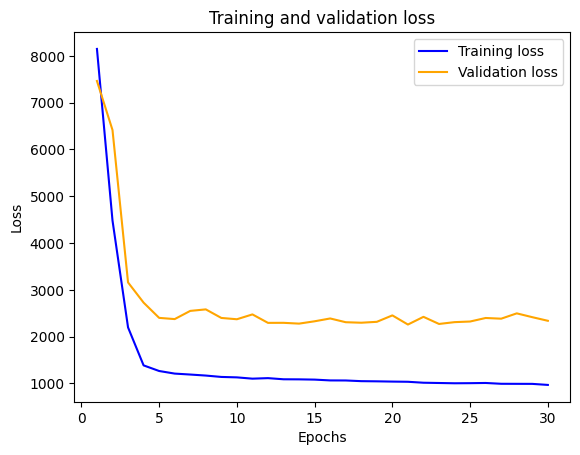

In [33]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
scores = model.evaluate(X_test, y_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y_pred = model.predict(X_test,verbose=1, batch_size=200)
y_true = y_test

66/66 [==============================] - 0s 6ms/step - loss: 2072.9810 - RMSE: 36.1948 - PHME_score: 81053.3516 - MAE: 36.1948

RMSE: 36.194820404052734

PHME: 81053.3515625

MAE: 36.194820404052734
66/66 [==============================] - 1s 3ms/step


In [35]:
predictions = model.predict(X_test)
predictions_avg = np.mean(predictions, axis=1)
predictions_flat = predictions_avg.flatten()
r_squared = r2_score(y_test, predictions_flat)
print("R-squared:", r_squared)

410/410 [==============================] - 1s 3ms/step
R-squared: 0.4040400081669452


##FD002

In [36]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same' , input_shape=(X2_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.1))
model.add(Conv1D(32 , 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[RMSE, PHME_score, MAE])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 26, 64)            256       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 26, 64)            0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 26, 64)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 26, 32)            6176      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 26, 32)            0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 26, 100)          

In [37]:
history = model.fit(X2_train, y2_train, batch_size=10, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
4301/4301 [==============================] - 43s 9ms/step - loss: 6490.3828 - RMSE: 63.3348 - PHME_score: 468520697856.0000 - MAE: 63.3348 - val_loss: 3630.3262 - val_RMSE: 49.1005 - val_PHME_score: 3509652.2500 - val_MAE: 49.1005
Epoch 2/30
4301/4301 [==============================] - 40s 9ms/step - loss: 2497.5193 - RMSE: 37.9622 - PHME_score: 11362926.0000 - MAE: 37.9622 - val_loss: 2203.3848 - val_RMSE: 37.8489 - val_PHME_score: 19673.7578 - val_MAE: 37.8489
Epoch 3/30
4301/4301 [==============================] - 40s 9ms/step - loss: 2184.6072 - RMSE: 35.7496 - PHME_score: 658459.3750 - MAE: 35.7496 - val_loss: 2325.8994 - val_RMSE: 40.0142 - val_PHME_score: 17463.6797 - val_MAE: 40.0142
Epoch 4/30
4301/4301 [==============================] - 39s 9ms/step - loss: 2174.5217 - RMSE: 35.5695 - PHME_score: 861808.1875 - MAE: 35.5695 - val_loss: 2120.2605 - val_RMSE: 37.9346 - val_PHME_score: 9373.5918 - val_MAE: 37.9346
Epoch 5/30
4301/4301 [==============================] -

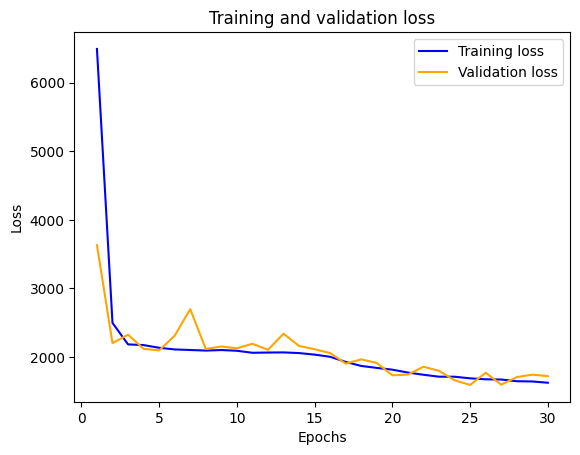

In [38]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
scores = model.evaluate(X2_test, y2_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y2_pred = model.predict(X2_test,verbose=1, batch_size=200)
y2_true = y2_test

170/170 [==============================] - 1s 5ms/step - loss: 2423.8848 - RMSE: 38.0850 - PHME_score: 247970.5000 - MAE: 38.0850

RMSE: 38.085044860839844

PHME: 247970.5

MAE: 38.085044860839844
170/170 [==============================] - 1s 3ms/step


In [40]:
predictions = model.predict(X2_test)
predictions_avg = np.mean(predictions, axis=1)
predictions_flat = predictions_avg.flatten()
r_squared = r2_score(y2_test, predictions_flat)
print("R-squared:", r_squared)

1063/1063 [==============================] - 4s 4ms/step
R-squared: 0.4058783612408925


##FD003

In [41]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same' , input_shape=(X3_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.1))
model.add(Conv1D(32 , 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[RMSE, PHME_score, MAE])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 26, 64)            256       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 26, 64)            0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 26, 64)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 26, 32)            6176      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 26, 32)            0         
 g1D)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 26, 100)          

In [42]:
history = model.fit(X3_train, y3_train, batch_size=10, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
1978/1978 [==============================] - 22s 10ms/step - loss: 17156.3379 - RMSE: 97.5671 - PHME_score: 893001216408158208.0000 - MAE: 97.5671 - val_loss: 12003.0547 - val_RMSE: 82.1447 - val_PHME_score: 230819981426688.0000 - val_MAE: 82.1447
Epoch 2/30
1978/1978 [==============================] - 20s 10ms/step - loss: 10118.9160 - RMSE: 76.7060 - PHME_score: 997309189980160.0000 - MAE: 76.7060 - val_loss: 10207.4785 - val_RMSE: 80.0675 - val_PHME_score: 6445358645248.0000 - val_MAE: 80.0675
Epoch 3/30
1978/1978 [==============================] - 18s 9ms/step - loss: 7374.2441 - RMSE: 59.7238 - PHME_score: 42358116712448.0000 - MAE: 59.7238 - val_loss: 5958.2939 - val_RMSE: 48.1180 - val_PHME_score: 92029304832.0000 - val_MAE: 48.1180
Epoch 4/30
1978/1978 [==============================] - 18s 9ms/step - loss: 3966.8867 - RMSE: 40.1354 - PHME_score: 744329183232.0000 - MAE: 40.1354 - val_loss: 5552.0991 - val_RMSE: 47.7513 - val_PHME_score: 32119783424.0000 - val_MAE: 4

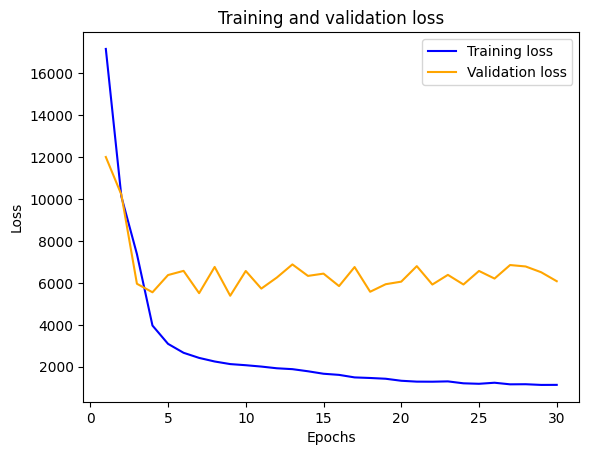

In [43]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
scores = model.evaluate(X3_test, y3_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y3_pred = model.predict(X3_test,verbose=1, batch_size=200)

83/83 [==============================] - 0s 6ms/step - loss: 6423.0718 - RMSE: 55.6855 - PHME_score: 547827810304.0000 - MAE: 55.6855

RMSE: 55.685516357421875

PHME: 547827810304.0

MAE: 55.685516357421875
83/83 [==============================] - 1s 3ms/step


In [45]:
predictions = model.predict(X3_test)
predictions_avg = np.mean(predictions, axis=1)
predictions_flat = predictions_avg.flatten()
r_squared = r2_score(y3_test, predictions_flat)
print("R-squared:", r_squared)

519/519 [==============================] - 2s 3ms/step
R-squared: 0.09454621497146254


##FD004

In [46]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same' , input_shape=(X4_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.1))
model.add(Conv1D(32 , 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[RMSE, PHME_score, MAE])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 26, 64)            256       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 26, 64)            0         
 g1D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 26, 64)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 26, 32)            6176      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 26, 32)            0         
 g1D)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 26, 100)          

In [47]:
history = model.fit(X4_train, y4_train, batch_size=10, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
4900/4900 [==============================] - 50s 9ms/step - loss: 10819.5586 - RMSE: 79.2842 - PHME_score: 1207507996318367744.0000 - MAE: 79.2842 - val_loss: 4636.5288 - val_RMSE: 54.1153 - val_PHME_score: 81939288.0000 - val_MAE: 54.1153
Epoch 2/30
4900/4900 [==============================] - 47s 10ms/step - loss: 5549.1157 - RMSE: 57.9347 - PHME_score: 2784934232064.0000 - MAE: 57.9347 - val_loss: 3898.2900 - val_RMSE: 49.9328 - val_PHME_score: 2709066.0000 - val_MAE: 49.9328
Epoch 3/30
4900/4900 [==============================] - 45s 9ms/step - loss: 5252.6851 - RMSE: 56.7240 - PHME_score: 253595353088.0000 - MAE: 56.7240 - val_loss: 4007.2324 - val_RMSE: 52.1673 - val_PHME_score: 552805.3750 - val_MAE: 52.1673
Epoch 4/30
4900/4900 [==============================] - 45s 9ms/step - loss: 5189.9019 - RMSE: 56.4998 - PHME_score: 210271076352.0000 - MAE: 56.4998 - val_loss: 4597.6670 - val_RMSE: 57.2323 - val_PHME_score: 260844.8281 - val_MAE: 57.2323
Epoch 5/30
4900/4900 [=

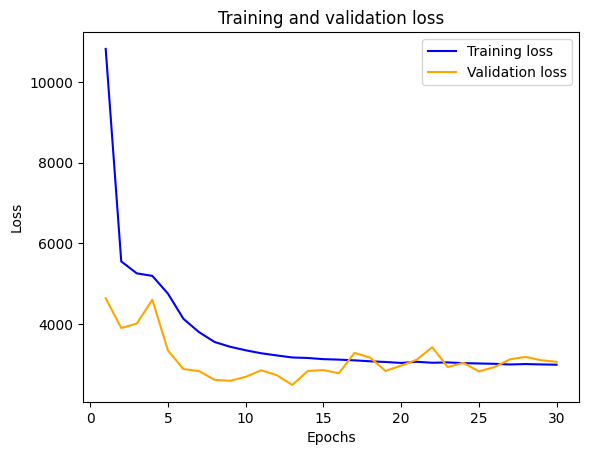

In [48]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
scores = model.evaluate(X4_test, y4_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y4_pred = model.predict(X4_test,verbose=1, batch_size=200)
y4_true = y4_test

207/207 [==============================] - 2s 5ms/step - loss: 5378.2837 - RMSE: 57.3030 - PHME_score: 289107771392.0000 - MAE: 57.3030

RMSE: 57.30297088623047

PHME: 289107771392.0

MAE: 57.30297088623047
207/207 [==============================] - 1s 3ms/step


In [50]:
predictions = model.predict(X4_test)
predictions_avg = np.mean(predictions, axis=1)
predictions_flat = predictions_avg.flatten()
r_squared = r2_score(y4_test, predictions_flat)
print("R-squared:", r_squared)

1288/1288 [==============================] - 5s 4ms/step
R-squared: 0.3668834117751655
